# Training linear model

In [150]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

fname = 'train.csv'
data = pd.read_csv('preprocessed2_' + fname, index_col='Id')
n_examples, n_features = data.shape

X, y = data.drop(columns=['SalePrice']), data['SalePrice']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

X.columns

Index(['LotFrontage', 'LotArea', 'Street', 'Alley', 'Utilities', 'OverallQual',
       'YearBuilt', 'TotalBsmtSF', 'CentralAir', 'Electrical', 'GrLivArea',
       'PavedDrive', 'EnclosedPorch', 'PoolArea', 'Fence',
       'SaleCondition_Abnorml', 'SaleCondition_Normal',
       'SaleCondition_Partial', 'MSZoning_C (all)', 'MSZoning_RH',
       'MSZoning_RL', 'MSZoning_RM', 'NearArtery_or_Feedr', 'PositiveFeat',
       'BsmtQuartersQ', 'DeductionsFunctional', 'RegularityOfShape', 'TotBath',
       'KitchensRating', 'FireplacesRating', 'GarageRating', 'HasBasement'],
      dtype='object')

In [151]:
# generate polynomial features

def generate_polynomial(data):
    lst = ['OverallQual', 'GrLivArea',
           'GarageRating', 'YearBuilt',
           'FireplacesRating', 'KitchensRating', 'BsmtQuartersQ',
           'LotFrontage', 'LotArea']
    for feat in lst:
        for degree in [0.5, 1, 2, 3]:
            data[feat + ' ^ ' + str(degree)] = data[feat]**degree
    return data

X_train = generate_polynomial(X_train)

# apply normalization
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)


# the same for test set
X_test = generate_polynomial(X_test)
X_test = scaler.transform(X_test)

<ipython-input-151-b1e98829a4bb>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[feat + ' ^ ' + str(degree)] = data[feat]**degree
<ipython-input-151-b1e98829a4bb>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[feat + ' ^ ' + str(degree)] = data[feat]**degree


# Model Selection

In [152]:
from sklearn.linear_model import RidgeCV, LassoCV, ElasticNetCV
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import validation_curve
from sklearn.model_selection import cross_val_score

def rmse_cv(model):
    rmse = np.sqrt(-cross_val_score(model, X, y, scoring="neg_mean_squared_error"))
    return rmse

Linear models:

In [153]:
alpha_range = np.arange(0.01, 0.15, 0.01)

ridge = RidgeCV(alphas = alpha_range, scoring="neg_mean_squared_error").fit(X_train, y_train)
lasso = LassoCV(alphas = alpha_range).fit(X_train, y_train)
elastic_net = ElasticNetCV(alphas=alpha_range).fit(X_train, y_train)

print(rmse_cv(ridge).mean())
print(rmse_cv(lasso).mean())
print(rmse_cv(elastic_net).mean())


# print(ridge.score(X_train, y_train), lasso.score(X_train, y_train), elastic_net.score(X_train, y_train))
# print(ridge.score(X_test, y_test), lasso.score(X_test, y_test), elastic_net.score(X_test, y_test))
# print(ridge.alpha_, lasso.alpha_, elastic_net.alpha_, elastic_net.l1_ratio_)

0.17162474607516068
0.17862231845423288
0.17569876218347225


XGBoost:

In [192]:
import xgboost as xgb


dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)
param = {'max_depth': 2, 
         'eta': 0.3, 
         'alpha': 1,
         'lambda': 0,
         'objective': 'reg:squarederror',
        'verbosity': 1}

num_round = 100
evallist = [(dtest, 'valid'), (dtrain, 'train')]

n_alpha = 100
alpha_range = np.linspace(0, 0.2, n_alpha)
scores_train = []
scores_test = []
for alpha in alpha_range: 
    param['alpha'] = alpha
    bst = xgb.train(param, dtrain, num_round, evallist, verbose_eval=0)
    scores_train.append(np.sqrt(mean_squared_error(bst.predict(dtrain), y_train)))
    scores_test.append(np.sqrt(mean_squared_error(bst.predict(dtest), y_test)))

plt.plot(alpha_range, np.array(scores_train), label = "train")
plt.plot(alpha_range, np.array(scores_test), label = "test")
plt.xlabel("alpha")
plt.ylabel("RMSE")
plt.legend();

In [197]:
param['alpha'] = 0
bst = xgb.train(param, dtrain, num_round, evallist, verbose_eval=num_round)

[0]	valid-rmse:8.09516	train-rmse:8.09696
[99]	valid-rmse:0.15200	train-rmse:0.11744


# Training ElasticNet

In [114]:
from sklearn.linear_model import ElasticNet, Lasso, LassoCV
model = ElasticNet(max_iter=10000).fit(X_train, y_train)


In [121]:
# score
from sklearn.metrics import mean_squared_error

print('R^2 score on train = {:.2e}'.format(model.score(X_train, y_train)))
print('R^2 score on test = {:.2e}'.format(model.score(X_train, y_train)))

y_pred = model.predict(X_train)
mse = mean_squared_error(y_train, y_pred)
print('RMSE = {:}'.format(rmse_cv(model).mean()))

y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print('RMSE on test = {:}'.format(np.sqrt(mse)))

R^2 score on train = 0.00e+00
R^2 score on test = 0.00e+00
RMSE = 0.2183008271196573
RMSE on test = 0.3039592832023523


count    1.08e+03
mean    -1.87e-16
std      3.00e-01
min     -6.61e-01
25%     -1.34e-01
50%     -7.48e-02
75%      2.35e-01
max      5.63e-01
Name: SalePrice, dtype: float64


Text(0.5, 1.0, 'Residuals, train set \n Score = 0.00e+00')

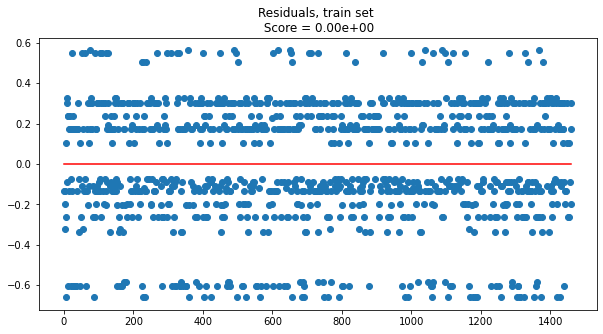

In [5]:
%matplotlib inline
pd.set_option('precision', 2)

residuals = model.predict(X_train) - y_train
print(residuals.describe())

plt.figure(figsize=(10, 5))
plt.scatter(residuals.index, residuals)
plt.plot([0, residuals.index.max()], [0, 0], color='red');
plt.title('Residuals, train set \n Score = {:.2e}'.format(model.score(X_train, y_train)))


count    3.62e+02
mean     3.17e-03
std      3.04e-01
min     -6.61e-01
25%     -1.34e-01
50%     -7.48e-02
75%      2.35e-01
max      5.63e-01
Name: SalePrice, dtype: float64


Text(0.5, 1.0, 'Residuals, test set \n Score = -1.08e-04')

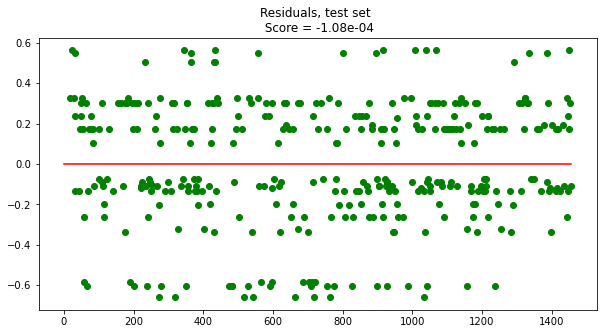

In [6]:
residuals = model.predict(X_test) - y_test
print(residuals.describe())

plt.figure(figsize=(10, 5))
plt.scatter(residuals.index, residuals, color='green')
plt.plot([0, residuals.index.max()], [0, 0], color='red');
plt.title('Residuals, test set \n Score = {:.2e}'.format(model.score(X_test, y_test)))


# Tuning regularization parameters

{'alpha': 0.2, 'copy_X': True, 'fit_intercept': True, 'l1_ratio': 0.5, 'max_iter': 10000, 'normalize': False, 'positive': False, 'precompute': False, 'random_state': None, 'selection': 'cyclic', 'tol': 0.0001, 'warm_start': False}


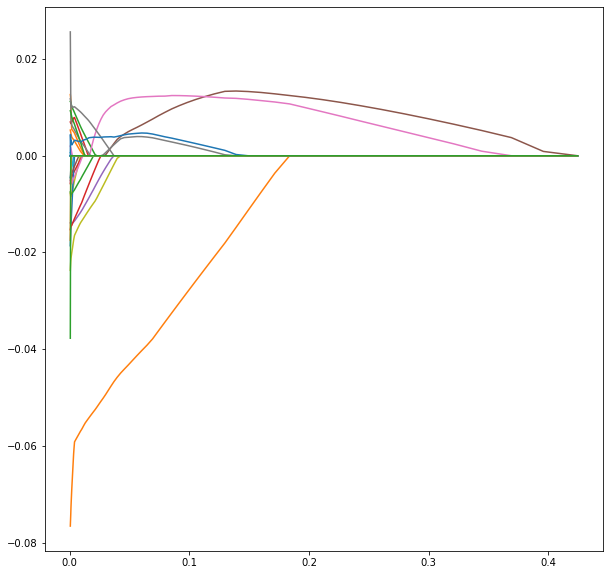

In [7]:
from sklearn.linear_model import ElasticNet, LinearRegression
model = ElasticNet(alpha=0.2, max_iter=10000).fit(X_train, y_train)

alphas, coefs, _ = model.path(X_train, y_train)
plt.figure(figsize=(10, 10))
for i in range(n_features):
    ax = plt.gca()
    ax.plot(alphas, coefs[i, :]);
    
# coefs.max()
# alphas.min(), alphas.max()
print(model.get_params())

In [18]:
# score
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_squared_error

def print_score(model):
    print(model)
    print('R^2 score on train = {:>10.2e}'.format(model.score(X_train, y_train)))
    print('R^2 score on test  = {:>10.2e}'.format(model.score(X_train, y_train)))

    y_pred = model.predict(X_train)
    mse = mean_squared_error(y_train, y_pred)
    print('MSE on train       = {:>10.2e}'.format(mse))

    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    print('MSE on test        = {:>10.2e}'.format(mse))
    
print_score(ElasticNet(alpha=0.2, l1_ratio=0).fit(X_train, y_train))
# print()
# print_score(ElasticNet(alpha=0.1).fit(X_train, y_train))
# print()
# print_score(ElasticNet(alpha=0.2, l1_ratio=1).fit(X_train, y_train))

ElasticNet(alpha=0.2, l1_ratio=0)
R^2 score on train =   6.87e-01
R^2 score on test  =   6.87e-01
MSE on train       =   2.81e-02
MSE on test        =   2.88e-02


/home/paul/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 16.063461401465187, tolerance: 0.009748603945682445
  model = cd_fast.enet_coordinate_descent(


In [9]:
# # choosing the best alpha
# from sklearn.model_selection import validation_curve
# alphas = np.linspace(0, 1, 50)
# train_scores, test_scores = validation_curve(ElasticNet(l1_ratio=0, max_iter=1000),
#                                              X_train, y_train,
#                                              param_name="alpha", 
#                                              param_range=alphas,
#                                              scoring=make_scorer(mean_squared_error))

In [10]:
# # train_scores = 
# # # train_scores
# # test_scores = )
# plt.figure(figsize=(10, 10))
# plt.plot(alphas, train_scores.mean(axis=1), label='train')
# plt.plot(alphas, test_scores.mean(axis=1), label='test')
# plt.legend()

# Training on entire dataset

In [11]:
X, y = data.drop(columns=['SalePrice']), data['SalePrice']
X = generate_polynomial(X)
scaler = StandardScaler().fit(X)
X = scaler.transform(X)

model = LinearRegression().fit(X, y)
# mean_squared_error(y, model.predict(X))
np.sqrt(mean_squared_error(y, model.predict(X)))
# data.shape

data.columns

Index(['LotFrontage', 'LotArea', 'Street', 'Alley', 'Utilities', 'OverallQual',
       'YearBuilt', 'TotalBsmtSF', 'CentralAir', 'Electrical', 'GrLivArea',
       'PavedDrive', 'EnclosedPorch', 'PoolArea', 'Fence',
       'SaleCondition_Abnorml', 'SaleCondition_Normal',
       'SaleCondition_Partial', 'MSZoning_C (all)', 'MSZoning_RH',
       'MSZoning_RL', 'MSZoning_RM', 'NearArtery_or_Feedr', 'PositiveFeat',
       'BsmtQuartersQ', 'DeductionsFunctional', 'RegularityOfShape',
       'SalePrice', 'TotBath', 'KitchensRating', 'FireplacesRating',
       'GarageRating', 'HasBasement'],
      dtype='object')

# Submitting

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

fname = 'test.csv'
data = pd.read_csv('preprocessed2_' + fname, index_col='Id')
n_examples, n_features = data.shape
X=data

def generate_polynomial(data):
    lst = ['OverallQual','GrLivArea',
           'GarageRating', 'YearBuilt',
           'FireplacesRating', 'KitchensRating', 'BsmtQuartersQ',
           'LotFrontage', 'LotArea']
    for feat in lst:
        for degree in [0.5, 1, 2, 3]:
            data[feat + ' ^ ' + str(degree)] = data[feat]**degree
    return data

X = generate_polynomial(X)
X = X.fillna(0)
print(pd.isna(X).sum().sort_values())

X = scaler.transform(X)
y_pred = model.predict(X)
ser = pd.Series(np.exp(y_pred), index=data.index)
ser.to_csv('subm.csv')

LotFrontage             0
OverallQual ^ 3         0
GrLivArea ^ 0.5         0
GrLivArea ^ 1           0
GrLivArea ^ 2           0
                       ..
MSZoning_RM             0
MSZoning_RL             0
MSZoning_RH             0
DeductionsFunctional    0
LotArea ^ 3             0
Length: 70, dtype: int64


ValueError: X has 70 features, but this StandardScaler is expecting 68 features as input.